In [1]:
# Load Environments:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import math
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

## Load Data for Testing / Validation

In [2]:
class Load_Dataset(Dataset):
    def __init__(self, file):
        tx = np.loadtxt(file, delimiter=',', dtype=np.float64, skiprows=1)
        self.t = torch.from_numpy(tx[:,0]).float() # First row
        self.x = torch.from_numpy(tx[:,1]).float() # Second row
        self.Tf = torch.from_numpy(tx[:,2]).float() # Thrid row
        self.n_samples = tx.shape[0] # Number of rows

    def __getitem__(self, index):
        return self.t[index], self.x[index], self.Tf[index]
    
    def __len__(self):
        return self.n_samples
    
    def create_input(self):
        return torch.stack((self.t, self.x), dim=1)

## PINN Architecture

In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_layers, neurons, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dim = input_dim
        # Number of output dimensions m
        self.output_dim = output_dim
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.hidden_layers = hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.output_activation=nn.ReLU()

        self.input_layer = nn.Linear(self.input_dim, self.neurons)
        # List with all Hidden Layers:
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(self.hidden_layers - 1)])

        # Output Layer:
        self.output_layer = nn.Linear(self.neurons, self.output_dim)

        # Random Weight Initialization
        self.retrain_seed = retrain_seed
        self.init_xavier()

    def forward(self, x):
        # First fully conncected neural network:
        x = self.activation(self.input_layer(x))

        # Feed forward through all hidden layers:
        for _, layer in enumerate(self.hidden_layers):
            x = self.activation(layer(x))

        # Feed forward to the output Layer:
        x = self.output_activation(self.output_layer(x))
        return x
    
    # Function provided from the tutorial to initialize the weights:
    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

## PINN Trainer with all relevant Functions

In [4]:
class PINN_Trainer:
    def __init__(self, n_int_, 
                 n_sb_, n_tb_, 
                 alpha_f_ = 0.005, 
                 h_f_ = 5,
                 T_hot_ = 4,
                 T0_ = 1,
                 T_cold_ = 1,
                 data_ = '/home/yannick/ETH_Zurich/AISE/Project_1/Task2/DataSolution.txt',
                 ):

        self.n_int = n_int_     # Number of Interior Domain Points
        self.n_sb = n_sb_       # Number of Spacial Boundary Points
        self.n_tb = n_tb_       # Number of Temporal Boundary Points

        # Dataset with measurement Data:
        self.dataset_name = data_
        self.dataset = Load_Dataset(self.dataset_name)

        # Parameters:
        self.alpha_f = alpha_f_

        self.h_f = h_f_

        self.T_hot = T_hot_
        self.T_cold = T_cold_
        self.T0 = T0_

        # Fluid velocity:
        # Charging Phase: u_f = 1
        # Idle Phase u_f = 0
        # Discharging Phase u_f = -1
        self.u_f_pars = [1, 0, -1]

        # Number of cycles:
        # Descripton of one cycle:
        # 1) Charging Phase
        # 2) Idle Phase
        # 3) Discharging Phase
        # 4) Idle Phase
        self.cycles = 2
        # Duration of each Phase:
        self.dt_phase = 1
        # Tensor with all phases:
        # 0 if 0 <= t < 1
        # 1 if 1 <= t < 2
        # 2 if 2 <= t < 3
        # 3 if 3 <= t < 4
        self.phases = torch.linspace(0, 3, steps = 4, dtype=int)

        # Domain: x = [0, 1], t = [0, 8]
        self.domain = torch.tensor([[0, 8],     # Time Domain
                                    [0, 1]])    # Space Domain  
        
        # From the image provided in the exercise sheet it becomes evident, that there are
        # certain regions of interests, where we want additional interior points!
        # Note roi ... region of interest
        # Option 1:
        self.n_roi = 4 * self.n_int # region of interest 2 times the number of interior points in addition!
        self.roi = []
        for i in range(1,8):
            self.roi.append(torch.tensor([[i-0.2, i+0.2], [0., 1.]]))
        # NOTE: it tourned out that with -0.2 and +0.2, best results could be realized, with a bigger bandwidth
        # the results became worse!
        
        # Number of space Dimensions
        self.space_dim = 1
        self.time_dim = 1
        self.output_dim = 1 # fluid and solid

        # Parameter to balance role of data and PDE
        self.lambda_u = 5

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # NN to approximate the solution of the underlying PDEs
        # Since the equations are still coupled the output has the following form: 
        # 1. Fluid
        # 2. Solid
        self.hidden_layer = 5
        self.neurons = 25
        self.seed = 42
        self.approximate_solution_Tf = NeuralNet((self.time_dim + self.space_dim), 
                                              self.output_dim, 
                                              self.hidden_layer+1, 
                                              self.neurons, 
                                              self.seed).to(self.device)
        
        self.approximate_solution_Ts = NeuralNet((self.time_dim + self.space_dim), 
                                              self.output_dim, 
                                              self.hidden_layer-1, 
                                              self.neurons-5, 
                                              self.seed).to(self.device)
        

        # Sobol Sequence Generator:
        # The sobol engine produces points between 0 and 1, hence no transform function is required!
        self.soboleng = torch.quasirandom.SobolEngine(dimension = self.domain.shape[0])

        # Optimizer:
        # self.optimizer = optim.Adam(self.approximate_solution_Tf.parameters())

        self.n_epochs = 1
        self.optimizer = optim.LBFGS(list(self.approximate_solution_Tf.parameters()) + list(self.approximate_solution_Ts.parameters()),
                                     lr = float(0.5),
                                     max_iter=50000,
                                     max_eval=50000,
                                     history_size=150,
                                     line_search_fn="strong_wolfe",
                                     tolerance_change=1.0 * np.finfo(float).eps)

        # Training Sets as Torch DataLoader:
        self.training_set_sb, self.training_set_tb, self.training_set_int = (self.assemble_datasets())


    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert_total(self, tens):
        assert(tens.shape[1] == self.domain.shape[0])
        return tens * (self.domain[:,1] - self.domain[:,0]) + self.domain[:,0]
    
    def convert_partial(self, tens, part_domain):
        assert(tens.shape[1] == part_domain.shape[0])
        return tens * (part_domain[:,1] - part_domain[:,0]) + part_domain[:,0]

    
    # Function returning the input-output tensor required to
    # assemble the training set S_tb corresponding to the temporal boundary.
    # Note: that the input gives back the points of the boundary, whereas the output
    # gives back the actual Temperature Values at the Boundary!
    def add_temporal_boundary_points(self):
        t0 = self.domain[0, 0]

        input_tb = self.convert_total(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.full((input_tb.shape[0], 1), self.T0)

        return input_tb, output_tb
    
    def masking_function(self, input_sb):
        # First row has the time dependency
        # Second row has the space dependency

        # This function should pass all the indices for each Phase!
        input_copy = torch.clone(input_sb)

        # Extract only the times:
        t = input_copy[:,0]
        for i in range(1, self.cycles):
            mask = t > 4 * i
            t[mask] = t[mask] - 4 * i
        
        # Now all times are in between [0, 4] which allows us to mask the problem
        logical_operator = torch.zeros((len(t), len(self.phases)), dtype = int)
        # logical_operator_x0 = torch.zeros((len(t), len(self.phases)), dtype = int)
        # logical_operator_xL = torch.zeros((len(t), len(self.phases)), dtype = int)
        
        for phase in range(len(self.phases)):
            # since dt for the phase is 1 we don't need to care about that!
            if phase == 3:
                logical_operator[:,phase] = torch.logical_and(t >= phase, t <= (phase+1))
            else:
                logical_operator[:,phase] = torch.logical_and(t >= phase, t < (phase+1))
            # idx = torch.nonzero(logical_operator[:,phase]).reshape(-1,) # row vector
            # logical_operator_x0[:,phase] = torch.logical_and(torch.logical_and(t >= i, t < (i+1)), input_copy[:,1] == 0)
            # logical_operator_xL[:,phase] = torch.logical_and(torch.logical_and(t >= i, t < (i+1)), input_copy[:,1] == 1)

        # Total result would be:
        # idx = torch.where(logical_operator)
        idx_0 = torch.where(logical_operator[:,0])[0]
        idx_1 = torch.where(logical_operator[:,1])[0]
        idx_2 = torch.where(logical_operator[:,2])[0]
        idx_3 = torch.where(logical_operator[:,3])[0]

        return idx_0, idx_1, idx_2, idx_3



    # Function returning the input-output tensor required to
    # assemble the training set S_sb corresponding to the spatial boundary.
    def add_spatial_boundary_points(self):
        x0 = self.domain[1, 0]
        xL = self.domain[1, 1]

        # The problem is that with soboleng not all points are distributed
        # equally through all phases in the two cycles, hence we sort of want
        # to force this behaviour!
        input_sb_0 = torch.tensor([])
        input_sb_L = torch.tensor([])

        # input_sb = self.convert_total(self.soboleng.draw(self.n_sb))

        n_sb_partial = self.n_sb // (len(self.phases) * self.cycles)

        for phase in range(len(self.phases) * self.cycles):

            partial_domain = torch.tensor([[phase, phase + 1],      # Time Domain
                                           [0, 1]])                 # Space Domain 

            input_sb_partial = self.convert_partial(self.soboleng.draw(n_sb_partial), partial_domain)

            input_sb_partial_0 = torch.clone(input_sb_partial)
            input_sb_partial_0[:,1] = torch.full(input_sb_partial_0[:, 0].shape, x0)

            input_sb_partial_L = torch.clone(input_sb_partial)
            input_sb_partial_L[:,1] = torch.full(input_sb_partial_L[:, 0].shape, xL)

            input_sb_0 = torch.cat((input_sb_0, input_sb_partial_0), 0)
            input_sb_L = torch.cat((input_sb_L, input_sb_partial_L), 0)


        # input_sb_0 = torch.clone(input_sb)
        # input_sb_0[:, 1] = torch.full(input_sb_0[:, 0].shape, x0)

        # input_sb_L = torch.clone(input_sb)
        # input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        # Output only fluid relevant!
        output_sb_0 = torch.zeros((input_sb_0.shape[0], 1))
        output_sb_L = torch.zeros((input_sb_L.shape[0], 1))

        # note that the idle states are not relevant for the boundary points (= 0)
        # Note that input_sb_0 and input_sb_L have the same times t in the first row!
        idx_charge, _, idx_discharge, _ = self.masking_function(input_sb_0)

        # Dirichlet Boundary Condition for the Fluid at x == 0 and t == Phase 0
        output_sb_0[idx_charge] = self.T_hot
        # Dirichlet Boundary Condition for the Fluid ad x == xL and t == Phase 2
        output_sb_L[idx_discharge] = self.T_cold
        
        # Now return only 2 arrays:
        return (
            torch.cat([input_sb_0, input_sb_L], 0),
            torch.cat([output_sb_0, output_sb_L], 0)
        )


    # Function returning the input-output tensor required to assemble
    # the training set S_int corresponding to the interior domain
    # where the PDE is enforced.
    def add_interior_points(self):
        input_int = torch.tensor([])
        output_int = torch.tensor([])

        input_int_domain = self.convert_total(self.soboleng.draw(self.n_int))
        output_int_domain = torch.zeros((input_int_domain.shape[0], 1))

        input_int = torch.cat((input_int, input_int_domain), 0)
        output_int = torch.cat((output_int, output_int_domain), 0)

        # Number of points for each region of interest (roi):
        # Option 1:
        n_region = self.n_roi // len(self.roi)
        
        for region in self.roi:
            # Option 1:
            input_roi = self.convert_partial(self.soboleng.draw(n_region), region)
            # Option 2:
            # input_roi = self.convert_partial(self.soboleng.draw(self.n_roi), region)
            output_roi = torch.zeros((input_roi.shape[0], 1))

            input_int = torch.cat((input_int, input_roi), 0)
            output_int = torch.cat((output_int, output_roi), 0)

        return input_int, output_int
    
    # Function returning the training sets S_sb_s, S_sb_f, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(
            torch.utils.data.TensorDataset(input_sb, output_sb),
            batch_size=2 * self.space_dim*(self.n_sb //(len(self.phases)*self.cycles))*len(self.phases)*self.cycles, shuffle=False)
        training_set_tb = DataLoader(
            torch.utils.data.TensorDataset(input_tb, output_tb),
            batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(
            torch.utils.data.TensorDataset(input_int, output_int),
            batch_size=self.n_int + (self.n_roi//len(self.roi))*len(self.roi), shuffle=False)

        return training_set_sb, training_set_tb, training_set_int
    
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution_Tf(input_tb).reshape(-1,)
        return u_pred_tb
    
    def apply_boundary_conditions(self, input_sb):

        input_sb.requires_grad = True

        # Get all the phases!
        # idx_charge, idx_idle_0, idx_discharge, idx_idle_1 = self.masking_function(input_sb)
        idx_charge, _, idx_discharge, _ = self.masking_function(input_sb)
        # Since x == x0 and x == xL are halfed:
        idx_half = int(len(input_sb[:,1]) / 2)

        u_pred_sb_Tf = self.approximate_solution_Tf(input_sb).reshape(-1,)

        gradients_Tf_x = torch.autograd.grad(u_pred_sb_Tf.sum(), input_sb, create_graph=True)[0][:,1]

        # Neumann Boundary Condition is required at x == 0:
        # While Discharging and in the Idle Phase!
        # Note that x == 0 is from 0 to idx_half only!
        # u_Tf_0 = u_pred_sb_Tf.clone()
        # u_Tf_0[idx_idle_0] = gradients_Tf_x[idx_idle_0]
        # u_Tf_0[idx_discharge] = gradients_Tf_x[idx_discharge]
        # u_Tf_0[idx_idle_1] = gradients_Tf_x[idx_idle_1]
        u_Tf_0 = gradients_Tf_x.clone()
        u_Tf_0[idx_charge] = u_pred_sb_Tf[idx_charge]
        u_Tf_0_half = u_Tf_0[:idx_half]

        # Neumann Boundary Condition is also required at x == xL:
        # Only while Charging and in Idle State:
        # Note that x == xL is from idx_half to the end (second half)
        # u_Tf_L = u_pred_sb_Tf.clone()
        # u_Tf_L[idx_charge] = gradients_Tf_x[idx_charge]
        # u_Tf_L[idx_idle_0] = gradients_Tf_x[idx_idle_0]
        # u_Tf_L[idx_idle_1] = gradients_Tf_x[idx_idle_1]
        u_Tf_L = gradients_Tf_x.clone()
        u_Tf_L[idx_discharge] = u_pred_sb_Tf[idx_discharge]
        u_Tf_L_half = u_Tf_L[idx_half:]

        u_pred_Tf_total = torch.cat([u_Tf_0_half, u_Tf_L_half], 0)

        return u_pred_Tf_total

    

    # Function to compute the PDE residuals for the fluid:
    def compute_pde_residual(self, input_int):

        input_int.requires_grad = True

        # Get again from both cycles the corresponding Phase!
        # Note that at idle indices the value is zero hence it's not required
        idx_charge, _, idx_discharge, _ = self.masking_function(input_int)
        # Create the vector u with the corresponding value:
        u_f = torch.zeros(input_int.shape[0])
        u_f[idx_charge] = self.u_f_pars[0] # 1
        u_f[idx_discharge] = self.u_f_pars[2] # -1

        Tf = self.approximate_solution_Tf(input_int).reshape(-1,) #.reshape(-1,2) # Instead of .resphae(-1,)

        Ts = self.approximate_solution_Ts(input_int).reshape(-1,)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi

        grad_Tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        # grad_Tf_t = torch.clone(grad_Tf[:, 0])
        # grad_Tf_x = torch.clone(grad_Tf[:, 1])
        grad_Tf_t = grad_Tf[:, 0]
        grad_Tf_x = grad_Tf[:, 1]

        # Compute the second derivative (HINT: Pay attention to the dimensions! --> torch.autograd.grad(..., ..., ...)[...][...]
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:,1]

        # Compute the Residual
        residual = grad_Tf_t + u_f*grad_Tf_x - self.alpha_f*grad_Tf_xx + self.h_f*(Tf - Ts)

        return residual
    
    

    # Function to compute the total loss (weighted sum of spatial boundary loss,
    # temporal boundary loss and interior loss).
    def compute_loss(
        self, inp_train_sb, u_train_sb, inp_train_tb, 
        u_train_tb, inp_train_int, verbose=True):

        # Initial Condition Output only 1 row for the fluid needed!
        u_pred_tb_tot = self.apply_initial_condition(inp_train_tb)
        u_pred_tb = u_pred_tb_tot.reshape(-1,1) # Fluid Output!

        # Boundary Condition also only 1 row for the fluid!
        u_pred_sb_tot = self.apply_boundary_conditions(inp_train_sb)
        u_pred_sb = u_pred_sb_tot.reshape(-1,1)

        # Measurement Data for the Fluid!:
        inp_train_meas = self.dataset.create_input().to(self.device)
        # u_train_meas = self.dataset.Tf

        u_train_meas = torch.unsqueeze(self.dataset.Tf, dim=1).to(self.device) # column vector
        u_pred_meas_tot = self.approximate_solution_Tf(inp_train_meas)
        u_pred_meas = u_pred_meas_tot[:,0].reshape(-1,1) # Fluid

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])

        # Note there is a problem with the SHAPE
        # print("Shapes:")
        # print("u_pred_sb_f:", u_pred_tb_s.shape)
        # print("u_train_sb_f:", u_train_tb.shape)

        # Compute interior PDE residual.
        r_int = self.compute_pde_residual(inp_train_int)

        # Compute spatial boundary residual.
        r_sb = u_pred_sb - u_train_sb

        # Compute temporal boundary residual
        r_tb = u_pred_tb - u_train_tb

        # Compute the measurement residual:
        r_meas = u_pred_meas - u_train_meas

        # Compute losses based on the residuals.
        loss_sb = torch.mean(abs(r_sb)**2)
        loss_tb = torch.mean(abs(r_tb)**2)
        loss_int = torch.mean(abs(r_int)**2)
        loss_meas = torch.mean(abs(r_meas)**2)

        # print('loss_int = ', loss_int)
        # print('loss_tb = ', loss_tb)
        # print('loss_sb = ', loss_sb)
        # print('loss_meas = ', loss_meas)

        loss_u = loss_sb + loss_tb + loss_meas
        loss = torch.log10(self.lambda_u * loss_u + loss_int)
        if verbose:
           print(
               "Total loss: ",round(loss.item(), 4),
               "| PDE Loss: ", round(torch.log10(loss_u).item(), 4),
               "| Function Loss: ", round(torch.log10(loss_int).item(), 4)
          )

        return loss
    


    def fit(self, num_epochs, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    self.optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb.to(self.device), u_train_sb.to(self.device), inp_train_tb.to(self.device), u_train_tb.to(self.device), inp_train_int.to(self.device), verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                self.optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history
    

    def plot(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert_total(inputs)

        approx_Tf = self.approximate_solution_Tf(inputs)
        approx_Ts = self.approximate_solution_Ts(inputs)
        # exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(
            inputs[:, 0].detach(), inputs[:, 1].detach(),
            c=approx_Tf.detach(), cmap="jet")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("x")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(
            inputs[:, 0].detach(), inputs[:, 1].detach(), c=approx_Ts.detach(),
            cmap="jet")
        axs[1].set_xlabel("t")
        axs[1].set_ylabel("x")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution Fluid")
        axs[1].set_title("Approximate Solution Solid")

        plt.show()

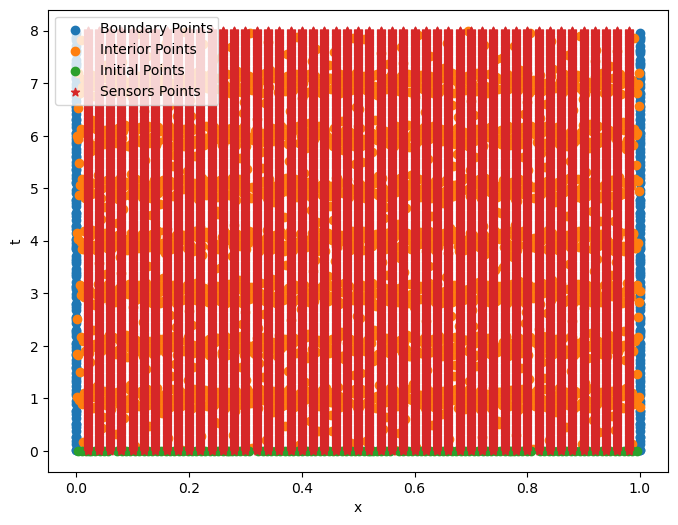

In [5]:
n_int = 512
n_sb = 128
n_tb = 128

pinn = PINN_Trainer(n_int, n_sb, n_tb)

input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_meas_ = pinn.dataset.create_input()
output_meas_ = pinn.dataset.Tf


plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_meas_[:, 1].detach().cpu().numpy(), input_meas_[:, 0].detach().cpu().numpy(), label="Sensors Points", marker="*")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()


################################  0  ################################


Total loss:  1.3152 | PDE Loss:  0.5856 | Function Loss:  0.1484
Total loss:  1.2977 | PDE Loss:  0.5483 | Function Loss:  0.3377
Total loss:  1.2895 | PDE Loss:  0.5246 | Function Loss:  0.4384
Total loss:  1.2739 | PDE Loss:  0.4799 | Function Loss:  0.5675
Total loss:  1.2288 | PDE Loss:  0.3615 | Function Loss:  0.7358
Total loss:  1.2121 | PDE Loss:  0.3069 | Function Loss:  0.7897
Total loss:  1.1786 | PDE Loss:  0.2907 | Function Loss:  0.7261
Total loss:  1.0106 | PDE Loss:  0.2597 | Function Loss:  0.0624
Total loss:  0.9915 | PDE Loss:  0.2393 | Function Loss:  0.0538
Total loss:  0.9214 | PDE Loss:  0.1805 | Function Loss:  -0.1147
Total loss:  0.865 | PDE Loss:  0.1356 | Function Loss:  -0.3044
Total loss:  0.851 | PDE Loss:  0.1275 | Function Loss:  -0.4079
Total loss:  0.8436 | PDE Loss:  0.1215 | Function Loss:  -0.4413
Total loss:  0.8362 | PDE Loss:  0.1154 | Function Loss:  -0.4723
Total loss:  0.8295 | PDE Loss:  0.11 | Function Loss:  -0.5048
Total loss:  0.8206 | P

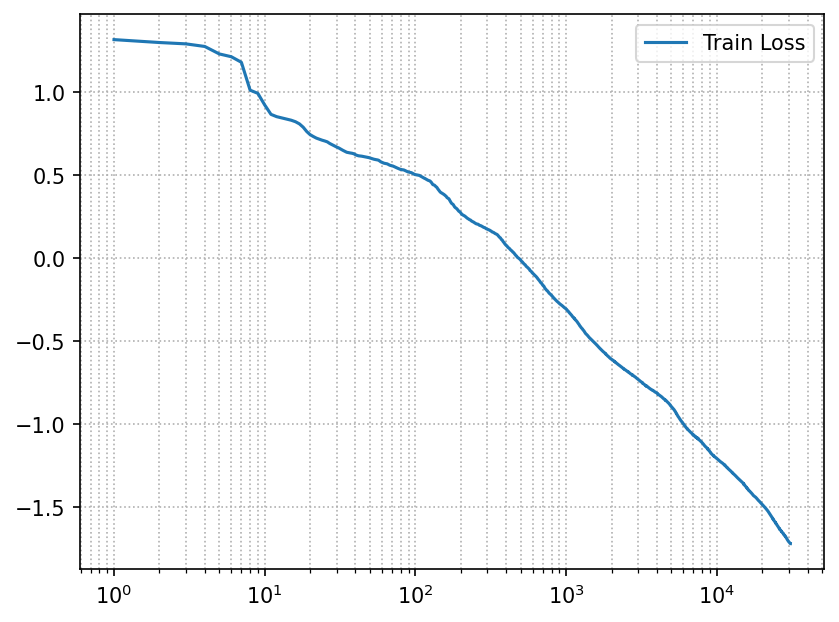

In [6]:
hist = pinn.fit(num_epochs=5, verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

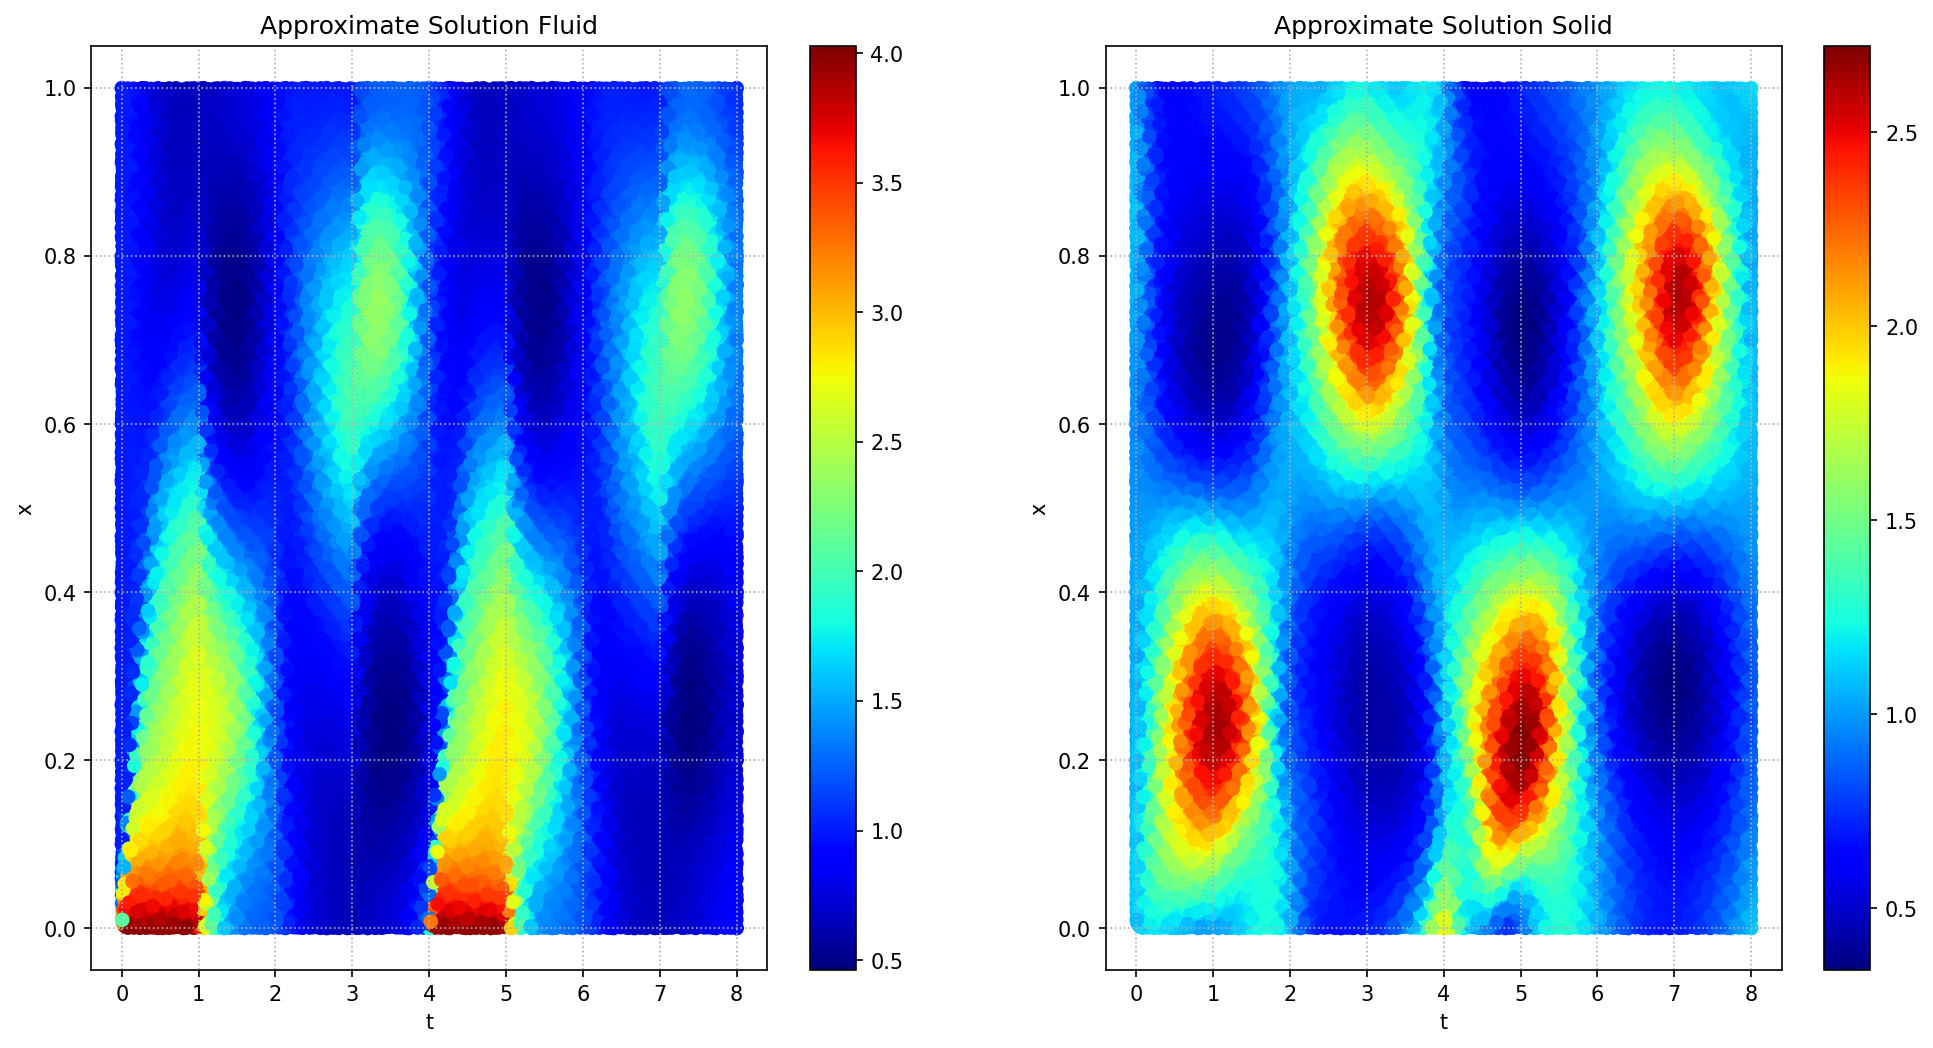

In [7]:
# Plot the Predictions
pinn.plot()

In [20]:
import pandas as pd
inputs = pinn.dataset.create_input()

approx_Tf = pinn.approximate_solution_Tf(inputs)
approx_Ts = pinn.approximate_solution_Ts(inputs)

results = torch.concat([inputs, approx_Ts], dim=1)
results = results.detach().numpy()
results = pd.DataFrame(results, columns=['x', 't', 'ts'])
# Uncomment if you want to save the results!
# results.to_csv('OutputTask2.txt', index=False)

# If necessary also the file can be stored with the fluid temperature:
# results = torch.concat([inputs, approx_Tf, approx_Ts], dim=1)
# results = results.detach().numpy()
# results = pd.DataFrame(results, columns=['x', 't', 'tf', 'ts'])
# results.to_csv('OutputTask2_tot.txt', index=False)



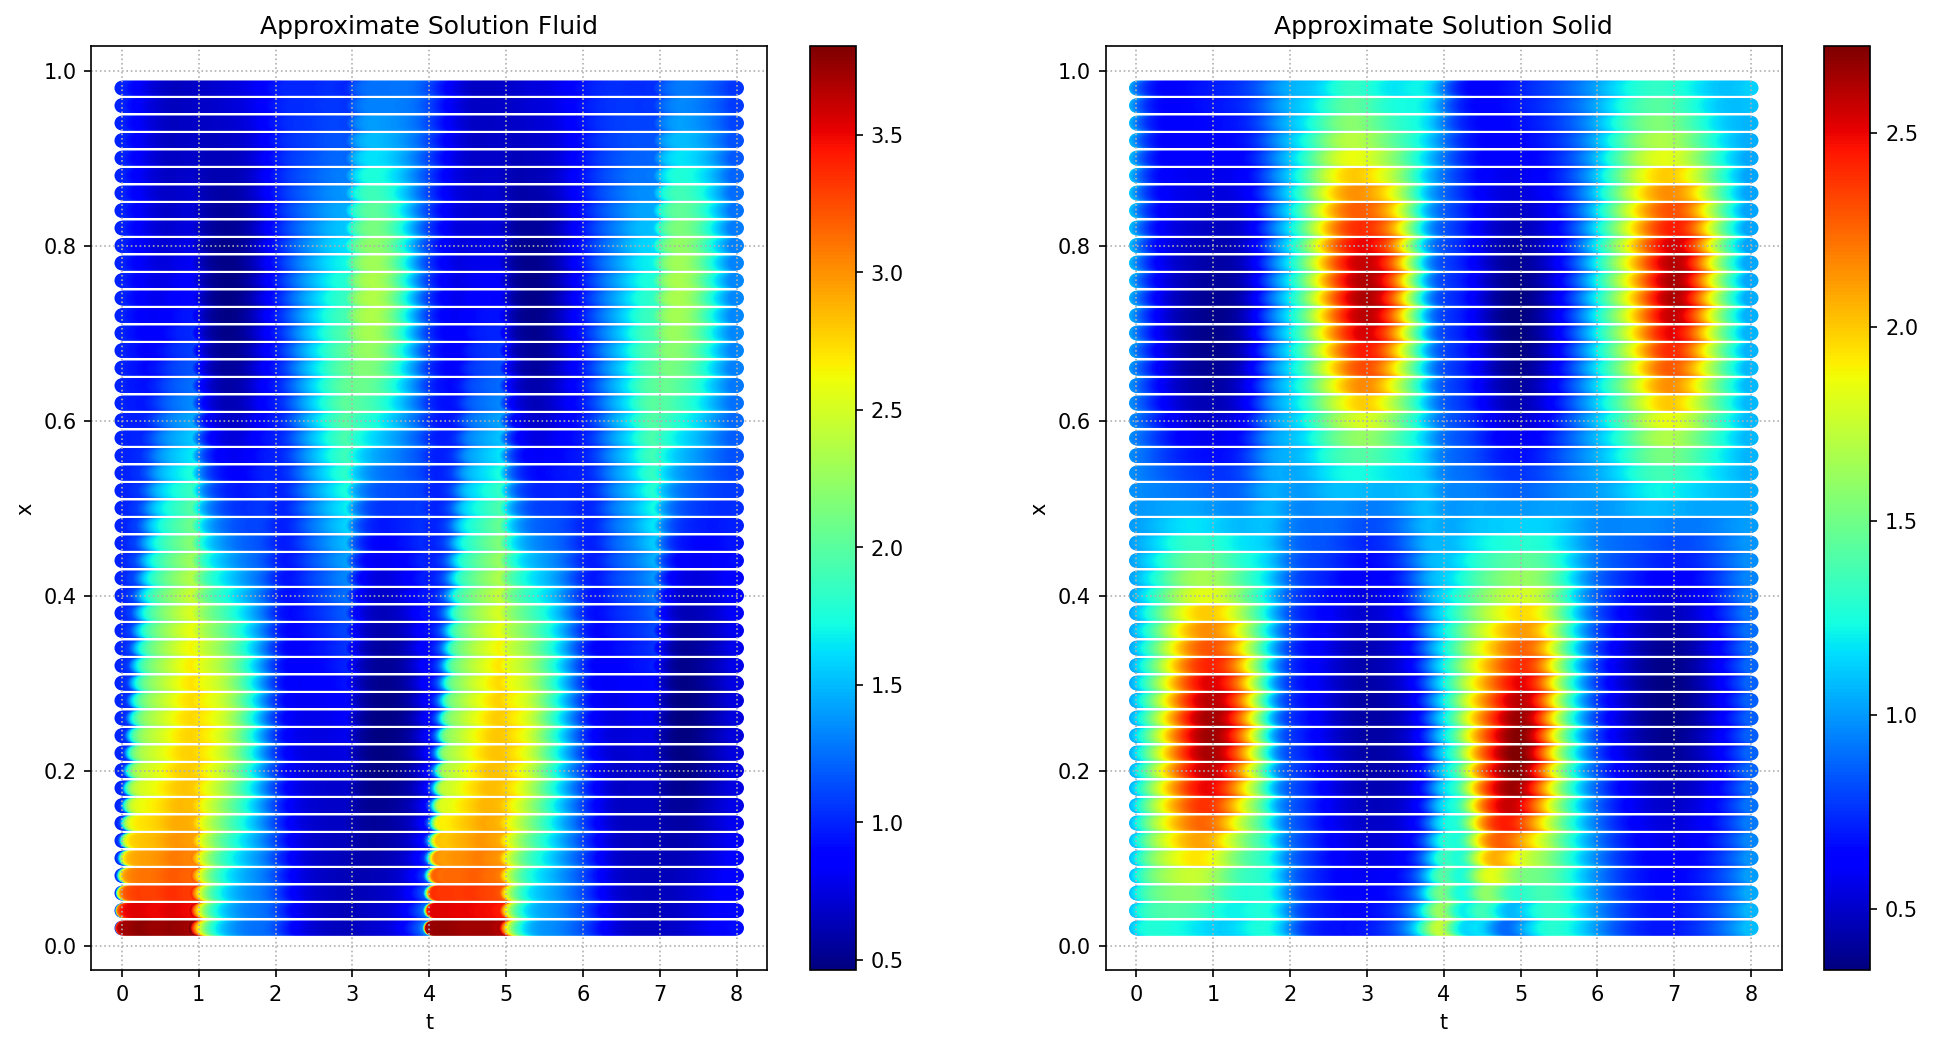

In [16]:
# Save the image of the predictions!
fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(
    inputs[:, 0].detach(), inputs[:, 1].detach(),
    c=approx_Tf.detach(), cmap="jet")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(
    inputs[:, 0].detach(), inputs[:, 1].detach(), c=approx_Ts.detach(),
    cmap="jet")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution Fluid")
axs[1].set_title("Approximate Solution Solid")

# Uncomment the following line to save the image!
# plt.savefig('predictions_task2.png')

Text(0.5, 1.0, 'Approximate Solution Solid')

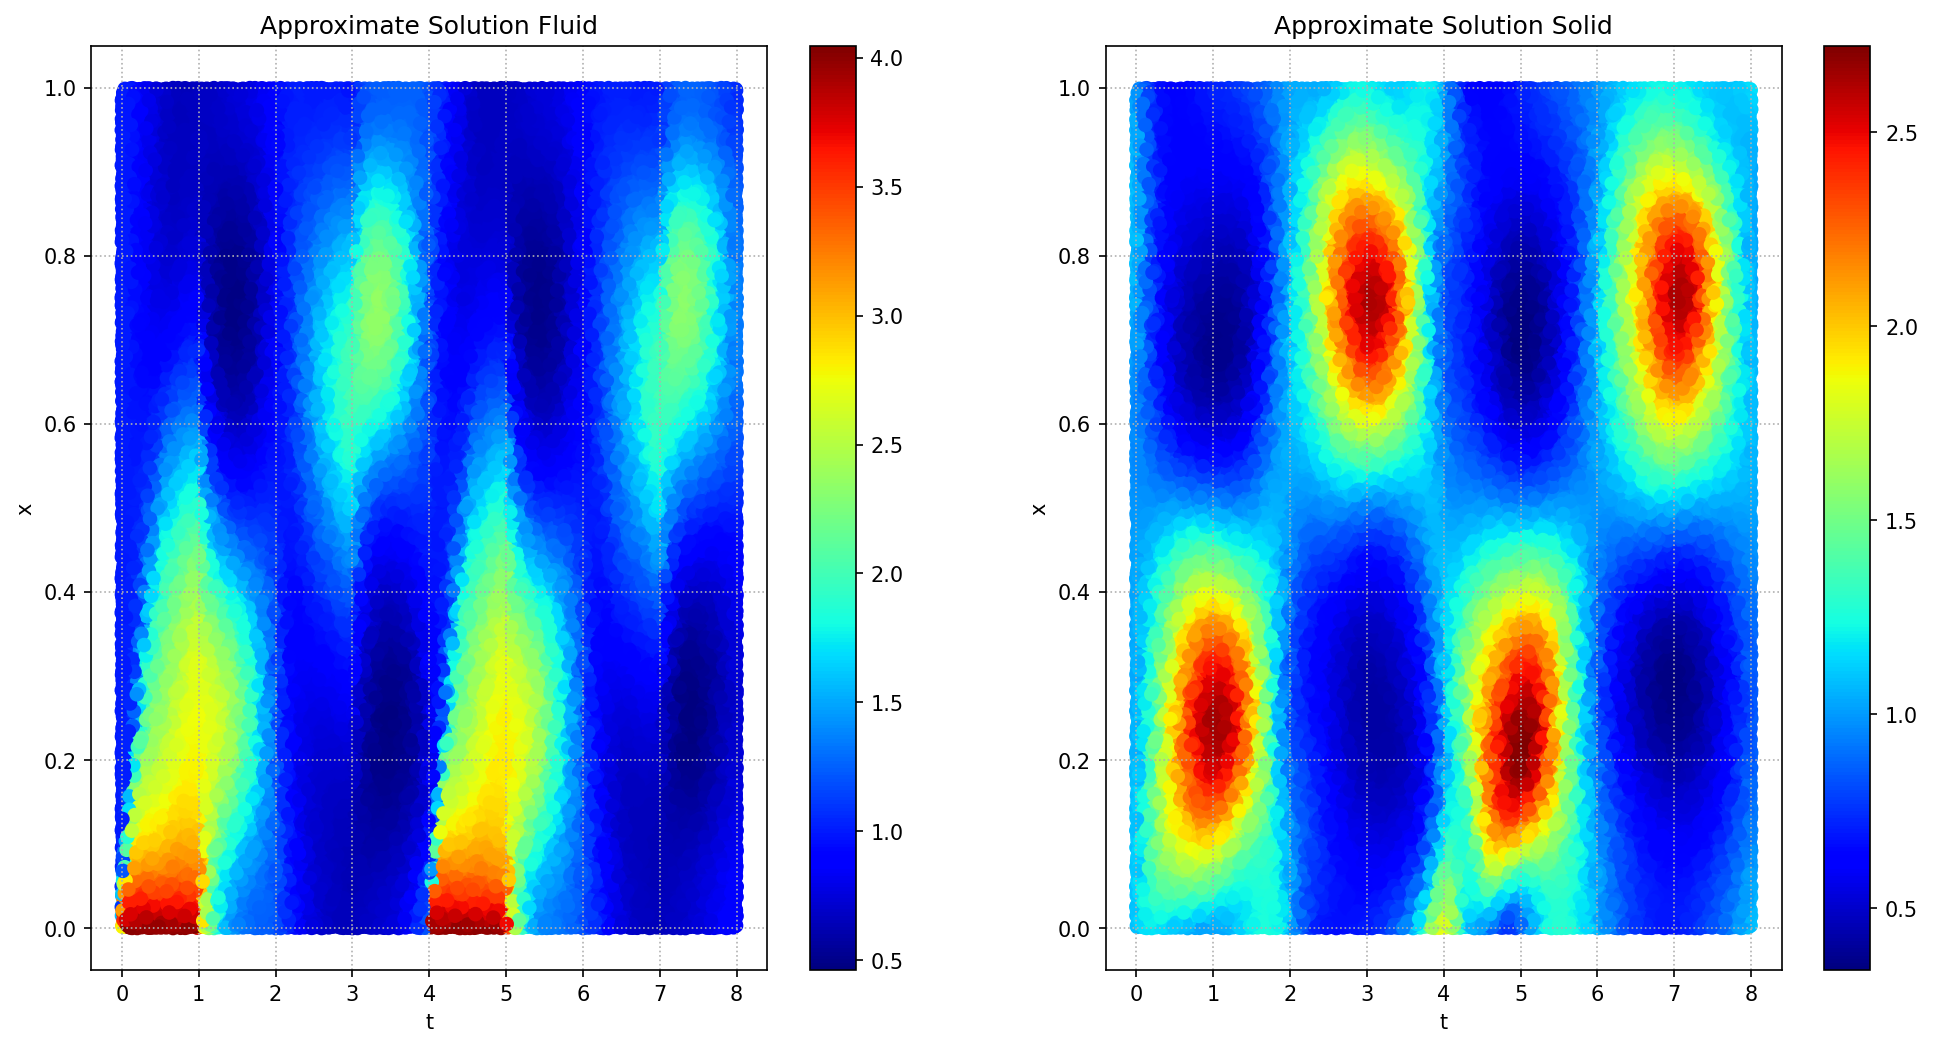

In [18]:
# Prediction with random points!
inputs = pinn.soboleng.draw(100000)
inputs = pinn.convert_total(inputs)

approx_Tf = pinn.approximate_solution_Tf(inputs)
approx_Ts = pinn.approximate_solution_Ts(inputs)
fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(
    inputs[:, 0].detach(), inputs[:, 1].detach(),
    c=approx_Tf.detach(), cmap="jet")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(
    inputs[:, 0].detach(), inputs[:, 1].detach(), c=approx_Ts.detach(),
    cmap="jet")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution Fluid")
axs[1].set_title("Approximate Solution Solid")

# Uncomment the following line to save the image!
# plt.savefig('predictions_rand_task2.png')